In [93]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import pickle
from datetime import datetime
from scipy.sparse import hstack
import json
from scipy import sparse
from sklearn.feature_extraction import text
import io,codecs

In [94]:
DIR = '/data/2/protest'

In [3]:
class Tokenizer:
    def __init__(self, collapse_mentions=False, collapse_digits=True):
        self.collapse_mentions = collapse_mentions
        self.collapse_digits = collapse_digits
        
    def tokenize(self, text):
        punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
        text = text.lower()
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        if self.collapse_mentions:
            text = re.sub('@\S+', 'MENTION', text)
        else:
            text = re.sub('@\S+', 'MENTION_\1', text)
        text = re.sub('http\S+', 'THIS_IS_A_URL', text)
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
        if self.collapse_digits: # Numbers help!
            text = re.sub(r'[0-9]', '9', text) 
        toks = []
        for tok in text.split():
            tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
            tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
            for subtok in tok.split():
                if re.search('\w', subtok):
                    toks.append(subtok)
        return toks

In [4]:
def print_top_terms(clf, vec, n=100):
    coefs = sorted(zip(vec.get_feature_names(),clf.coef_[0]),key=lambda x:x[1])
    print(coefs[0:30], '\n')
    print(coefs[-30:])
    #feats = np.array(vec.get_feature_names())
    #print('\n'.join(feats[np.argsort(clf.coef_[0])[::-1][:n]]))

In [5]:
#read file with stopwords
def read_stopwords(path):
    return [s.strip().lower() for s in open(path)]

In [6]:
#parse date from tweets
def parse_date(datestring):
    from datetime import datetime
    """ Input, e.g., Mon Aug 24 19:41:14 +0000 2015
    Output, e.g., datetime.datetime(2015, 8, 24, 0, 0)"""
    
    parts = datestring.split()
    var = datetime.strptime(parts[1]+' ' +parts[2]+' '+ parts[5],'%b %d %Y')
    return var

In [7]:
def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

In [8]:
def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

In [9]:
def iterate_Testing_instances(path,files_test):
    
    """
    Return an iterator over tuples containing:
    (N concatenated tweets, user, percentage of neighbors who used one of the keywords)
    For each user in path, we find the first tweet containing one of the specified keywords. 
    Then each 20 tweets are concatenated and also we get the percentage of neighbors who used one of the keywords
    during the same window time as those 20 tweets.
    """
    for _, _, arquivos in os.walk(path): arquivos
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    data1 = pickle.load(pkl_file)
    DIR2='/data/2/protest/mentions/'
    result1=0
    result2=0
    for fname in files_test:
        
        user = filename2user(arquivos[fname])
        lines = []
        var=None
        count=0
        date1=None
        date2=None
        
        for i, line in enumerate(open(path+arquivos[fname])):
            js = json.loads(line)
            
            if matches_keywords(js['text'], keywords):
                #print('test',user)
                v=''
                count=0
                #print('len of lines', len(lines))
                for k,l in enumerate(lines[:][::-1]):
                    #print(l)
                    v=v+l[0]
                    count=count+1
                    if count == 1:
                        date1 = l[1]
                        #print('date1',date1)
                    if count==20:
                        date2 = l[1]
                        #print('date2', date2)
                        if data1.has_node(user) == True:
                            result1,result2=neighbors_hashtag_use(user, DIR2, date2, date1)
                            if result2==0:
                                yield(v,user, float(0))
                            else:
                                yield(v,user, float(result1)/float(result2))
                        #print('count',count)
                        count=0
                        
                        v=None
                        v=""
                    elif(count<20 and k == (len(lines)-1)):  #PS.: if first tweet of user is with keyword this user is not counted!
                        #print('count',count)
                        date2 = l[1]
                        if data1.has_node(user) == True:
                            result1,result2=neighbors_hashtag_use(user, DIR2, date2, date1)
                            if result2==0:
                                yield(v,user, float(0))
                            else:
                                yield(v,user, float(result1)/float(result2))
                        count=0
                        
                        v=None
                        v=""
                break
            lines.append((js['text'],js['created_at']))

In [11]:
def neighbors_hashtag_use(user, DIR2,date1_pos, date2_pos, date1_neg=None, date2_neg=None):
    
    """
    neighors of each user are checked for the use of any of the keywords during same the window time defined of positive 
    and negative instancees (define as the time each set starts and finishes)
    """
    
    countpos=0
    countneg=0
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    data1 = pickle.load(pkl_file)
    for _, _, f in os.walk(DIR2): f
    neighbors=[]
    #print(user, 'is in the graph!')
    neighbors = data1.neighbors(user) #get all neighbors of the user
    #print(user, 's neighbors are: ', neighbors)
    #if len(neighbors)!=0:
    for n in neighbors:
        if n +'.txt' in f:#if that file is in the directory
            #print('vizinho: ', n)
            neighbor = open(DIR2 + n +'.txt','r')
            nlines = neighbor.readlines()
            for t in reversed(nlines):
                tweet_neighbor = json.loads(t) 
                #print(tweet_neighbor['created_at'])
                #print(parse_date(tweet_neighbor['created_at']) ,'>', parse_date(date1_pos) )
                if matches_keywords(tweet_neighbor['text'],keywords):
                    if parse_date(tweet_neighbor['created_at']) > parse_date(date1_pos) and parse_date(tweet_neighbor['created_at']) < parse_date(date2_pos):
                        #if date2_neg == None and date1_neg ==None:
                            #print(user, 'has', neighbors)
                            #print(n, 'posted keyword')
                        #print(n, 'posted keyword in', parse_date(tweet_neighbor['created_at']))
                        #print('entrou!!')
                        countpos = countpos+1
                        break
            if date2_neg != None and date1_neg !=None:
                for t in reversed(nlines):
                    tweet_neighbor = json.loads(t) 
                    if matches_keywords(tweet_neighbor['text'],keywords):
                        if parse_date(tweet_neighbor['created_at']) < parse_date(date2_neg) and parse_date(tweet_neighbor['created_at']) > parse_date(date2_neg):
                            #print(n, 'posted negkeyword in', parse_date(tweet_neighbor['created_at']))
                            #print('1entrou!!')
                            countneg = countneg+1
                            break
    if date2_neg != None and date1_neg !=None:                        
        return countpos, countneg, len(neighbors)
    else:
        return countpos, len(neighbors)
            


In [10]:
def iterate_instances_changed(files, keywords, window_sz, gap_sz,files_train):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username, percentage of neightbors who used one of the keywords)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, defined as window = N tweets prior to the matched tweet.
    We also create one negative instance, which is the same size as positive, but defined after a gap=g.
    We additionally filter users if they use one of the keywords in one of their first (2*window + gap)
    tweets. 
    Also we find neighbors (define as those with symetric mentions) who have also used one of the keywords 
    during positive or negative window 
    """
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    DIR2='/data/2/protest/mentions/'
    dic = defaultdict(tuple)
    pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    data1 = pickle.load(pkl_file)
    for _, _, f in os.walk(DIR2): f    
    for _, _, arquivos in os.walk(files): arquivos
        
    for fname in files_train:
        
        user = filename2user(arquivos[fname])
        #print('this is', user)
        lines = []
        #countneg=0
        #countpos=0
        #print('treino',user)
        #print(open(files+arquivos[fname]))
        for i, line in enumerate(open(files+arquivos[fname])):
            js = json.loads(line)
                # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', arquivos[fname], 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                #print('positive window starts in',pos_start)
                pos_end = i+1
                #print('positive window finishes in',pos_end)

                #print('lineslen: ',len(lines))
                date1_pos = lines[pos_start][1]
                #print('ksdjsk',lines[pos_start][1])
                #print(pos_end)
                date2_pos = lines[pos_end-2][1]

                neg_start = max(0, i - gap_sz - (2 * window_sz))
                #print('negative window starts in',neg_start)
                neg_end = i - gap_sz - window_sz
                #print('nagative window finishes in',neg_end)
                date1_neg = lines[neg_start][1]
                date2_neg = lines[neg_end][1]
                
                if data1.has_node(user) == True: #if that file is in the graph
                    result1, result2,result3 = neighbors_hashtag_use(user, DIR2, date1_pos, date2_pos, date1_neg, date2_neg)
                #print(result1, result2,result3)
                
                #dic[user]=((float(countpos)/float(len(neighbors))),float(countneg)/float(len(neighbors)))
                #print('diccc',dic)
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                #print('testeee',lines[0][pos_start:pos_end])
                testepos = " ".join(l[0] for l in lines[pos_start:pos_end])
                testeneg = " ".join(l[0] for l in lines[neg_start:neg_end])
                
                yield (testepos, 1, user, float(result1)/float(result3))
                yield (testeneg, 0, user, float(result2)/float(result3))
                
                #yield (testepos, 1, user, float(countpos)/float(len(neighbors)))
                #yield (testeneg, 0, user,float(countneg)/float(len(neighbors)))
                #countneg=0
                #countpos=0
                break
            lines.append((js['text'],js['created_at']))
    #print(dic)

In [95]:
#define vectorizer 
toker = Tokenizer(collapse_digits=False, collapse_mentions=True)

#Adding new stopwords to the model
stopwords = set(read_stopwords(DIR + '/stopwords.txt'))    
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

vectorizer = TfidfVectorizer(binary=False, decode_error='ignore',ngram_range=(1,1),
                                 max_df=1.0, min_df=2, use_idf=True,
                                 tokenizer=toker.tokenize,
                                 norm='l2', stop_words=set(my_stop_words))

In [13]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [97]:
def plot_probs(dictv,name):
    %pylab inline
    fig = plt.figure(figsize=(40,10))
 
    for k, v in dictv.items():
        i=1
        y=[]
        x=[]
        l=[]
        t = 1/len(dictv[k])
        for g in dictv[k]:
            y.append(g)
            x.append(i*t)
            i = i+1
        i=0
        plt.xlabel('% of total tweets')
        plt.ylabel('Probability')
        
        plt.plot(x,y,label=k,marker='o')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=10, mode="expand", borderaxespad=0., shadow=True, title="Users", fancybox=True)
        #plt.legend(bbox_to_anchor=[0,0], shadow=True, title="Legend", fancybox=True)
        
    plt.savefig('/home/elaine/Protest/protest/Brazil project/Plots/reanalysis/after/'+name)

In [86]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


#y_pred = model.predict(X)

def confusion_matrix(y, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm

def after_iterate_instances_changed(files, keywords, window_sz, gap_sz,files_train):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username, percentage of neightbors who used one of the keywords)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, defined as window = N tweets prior to the matched tweet.
    We also create one negative instance, which is the same size as positive, but defined after a gap=g.
    We additionally filter users if they use one of the keywords in one of their first (2*window + gap)
    tweets. 
    Also we find neighbors (define as those with symetric mentions) who have also used one of the keywords 
    during positive or negative window 
    """
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    DIR2='/data/2/protest/mentions/'
    dic = defaultdict(tuple)
    pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    data1 = pickle.load(pkl_file)
    for _, _, f in os.walk(DIR2): f    
    for _, _, arquivos in os.walk(files): arquivos
        
    for fname in files_train:
        
        user = filename2user(arquivos[fname])
        #print('this is', user)
        lines = []
        lines_neg = []
        #countneg=0
        #countpos=0
        #print('treino',user)
        #print(open(files+arquivos[fname]))
        for i, line in enumerate(open(files+arquivos[fname])):
            js = json.loads(line)
                # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', arquivos[fname], 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                lines.append((js['text'],js['created_at']))
            if not(matches_keywords(js['text'],keywords)):
                lines_neg.append((js['text'],js['created_at']))
    
                
                
        testepos = " ".join(l[0] for l in lines)
        testeneg = " ".join(l[0] for l in lines_neg)
                
        yield (testepos, 1, user)
        yield (testeneg, 0, user)

        """
        pos_start = i

        pos_end = (i+1)+window_sz


        #print('lineslen: ',len(lines))
        #date1_pos = lines[pos_start][1]
        #print('ksdjsk',lines[pos_start][1])
        #print(pos_end)
        #date2_pos = lines[pos_end-2][1]

        neg_start = max(0, i - gap_sz - (2 * window_sz))
        #print('negative window starts in',neg_start)
        neg_end = i - gap_sz - window_sz
        #print('nagative window finishes in',neg_end)
        #date1_neg = lines[neg_start][1]
        #date2_neg = lines[neg_end][1]

        #if data1.has_node(user) == True: #if that file is in the graph
        #    result1, result2,result3 = neighbors_hashtag_use(user, DIR2, date1_pos, date2_pos, date1_neg, date2_neg)
        #print(result1, result2,result3)

        #dic[user]=((float(countpos)/float(len(neighbors))),float(countneg)/float(len(neighbors)))
        #print('diccc',dic)
        # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
        #print('testeee',lines[0][pos_start:pos_end])


        #yield (testepos, 1, user, float(countpos)/float(len(neighbors)))
        #yield (testeneg, 0, user,float(countneg)/float(len(neighbors)))
        #countneg=0
        #countpos=0
        break
    #lines.append((js['text'],js['created_at']))
#print(dic)"""

0
read 576 instances into X training matrix with shape (576, 68512)
label distribution= Counter({0: 288, 1: 288})
(229, 68512)
229
58
accuracy: 1.0
precision recall f-scrore: (array([ 1.,  1.]), array([ 1.,  1.]), array([ 1.,  1.]), array([15, 15])) 

read 655 instances into X_ testing matrix with shape (655, 68512)
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
58
read 578 instances into X training matrix with shape (578, 67228)
label distribution= Counter({0: 289, 1: 289})
(230, 67228)
230
58
accuracy: 0.933333333333
precision recall f-scrore: (array([ 1.        ,  0.88235294]), array([ 0.86666667,  1.        ]), array([ 0.92857143,  0.9375    ]), array([15, 15])) 

read 1375 instances into X_ testing matrix with shape (1375, 67228)
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
58
read 578 instances into X training matrix with 

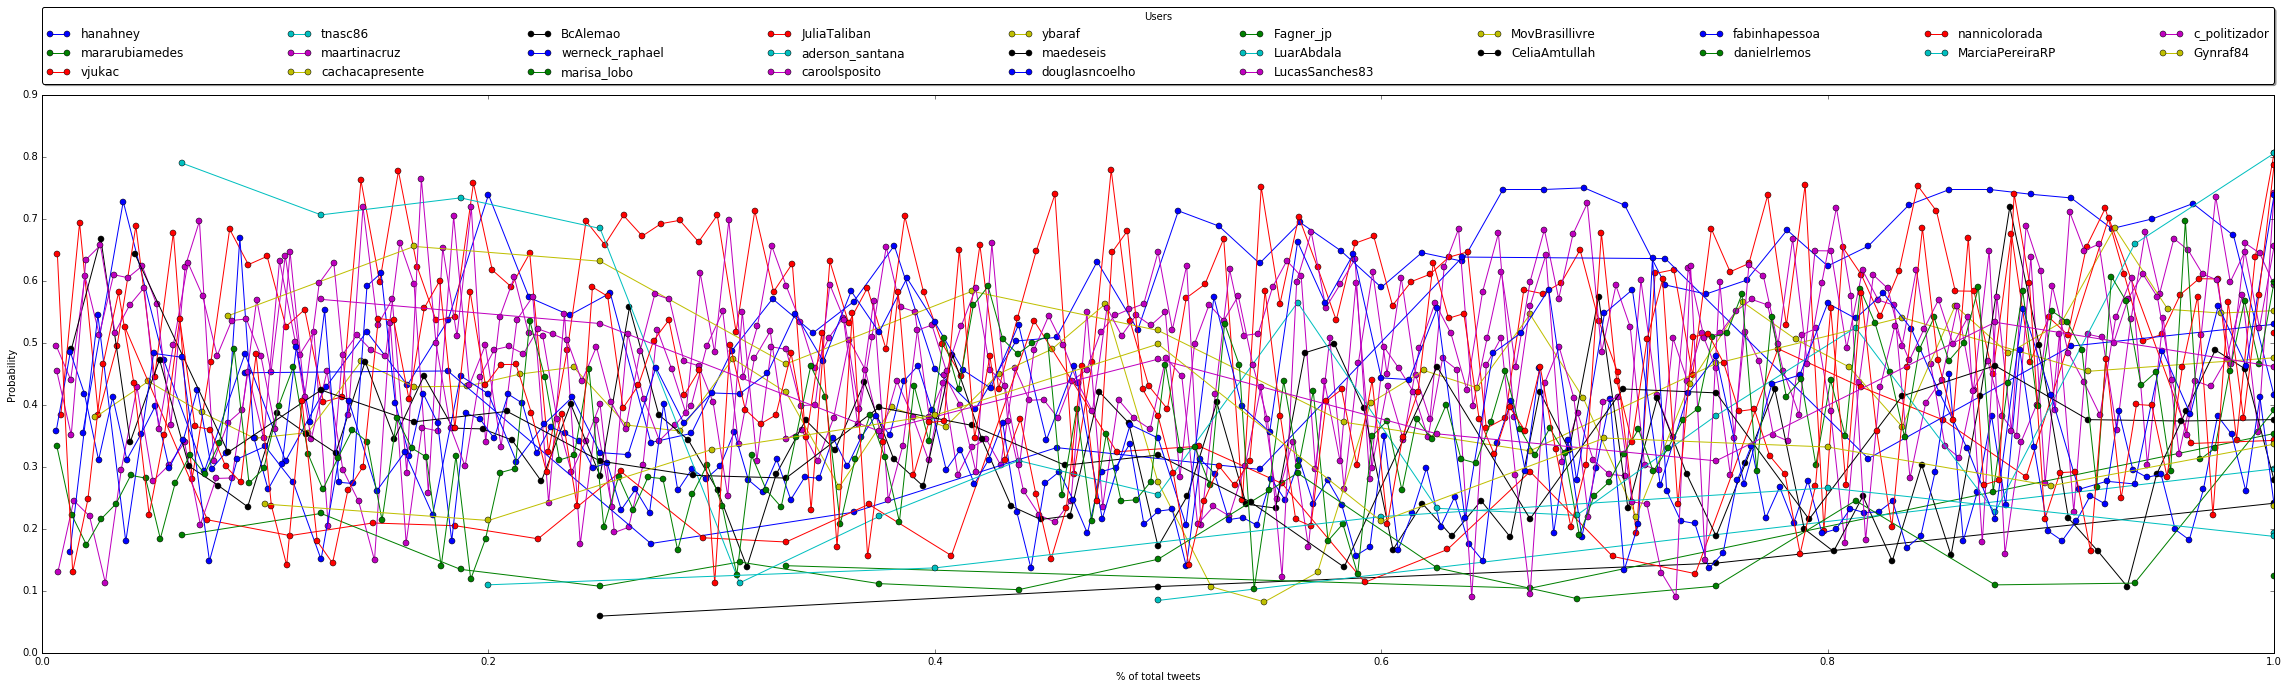

In [98]:
# cross validation process
"""
In each loop, diferent sets for training and testing are obtained, in order to have all users tested. 
We start calling iterate_instances_changed(), then it is vectorized as training set.
After we call iterate_Testing_instances(), to get testing set and predict it.
And then, we plot the results, as probability X % of tweets for each user.
"""

dictv = defaultdict(list)
newdictv = defaultdict(list)

model_mod = LogisticRegression(penalty='l2', C=1)

treino_y=[]
plots=[]
t=0
allusers=[]

for _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos

cv = KFold(len(arquivos), 10,shuffle=False)
preds=None
confusion_matrix=[]
for train_ind, test_ind in cv: 
    #print(len(train_ind)/5), len(test_ind)))
    #print(train_ind, test_ind)
    #files, keywords, window_sz, gap_sz,files_train
    print(len(treino_y[0:round(len(train_ind)/5)]))
    iterator = after_iterate_instances_changed(DIR + '/Timeline/', keywords, 20,100, train_ind)
    treino_y=[]
    users=[]
    neighbors=[]
    treino_X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not treino_y.append(x[1])) #and not neighbors.append(x[3]))
    #treino_X = sparse.hstack((treino_X)).tocsr()
    print('read %d instances into X training matrix with shape %s' % (len(users), str(treino_X.shape)))
    print('label distribution=', Counter(treino_y))
    
    #metrics
    from sklearn.metrics import precision_recall_fscore_support
    #y_true = treino_y
    print((treino_X[(round(len(train_ind)/5)+1):len(train_ind)].shape))
    print(len(treino_y[(round(len(train_ind)/5)+1):len(train_ind)]))
    print(len(treino_y[0:round(len(train_ind)/5)]))
    model_mod.fit(treino_X[(round(len(train_ind)*0.1)+1):len(train_ind)],treino_y[(round(len(train_ind)*0.1)+1):len(train_ind)])  
    y_pred = model_mod.predict(treino_X[0:(round(len(train_ind)*0.1)+1)])
    print('accuracy:',accuracy_score(treino_y[0:(round(len(train_ind)*0.1)+1)], y_pred))
    print('precision recall f-scrore:',precision_recall_fscore_support(treino_y[0:(round(len(train_ind)*0.1)+1)], y_pred),'\n')
    
    #confusion_matrix(treino_y[0:round(len(train_ind)/10)], y_pred)
    #confusion_matrix.append((treino_y[0:round(len(train_ind)/5)], y_pred))
    #print(accuracy_score(treino_y[0:round(len(train_ind)/5)], y_pred))
    
    iterator1 = iterate_Testing_instances(DIR + '/Timeline/', test_ind)
    users1=[]
    neighbors1=[]
    X_ = vectorizer.transform(x[0] for x in iterator1 if not users1.append(x[1])) #and not neighbors1.append(x[2]))
    #X_= sparse.hstack((X_).tocsr())
    print('read %d instances into X_ testing matrix with shape %s' % (len(users1), str(X_.shape)))


    treino_y = np.array(treino_y)
    model_mod.fit(treino_X,treino_y)   
    preds = model_mod.predict_proba(X_)
    #print(len(preds))
    
    #iterator1 = iterate_Testing_instances(DIR + '/Timeline/', test_ind)
    #iter1=list(iterator1)
    #print(users1)
    for o in zip(users1, preds):
        #print(o[1][1])
        #allusers.append(o[0])
        dictv[(o[0])].append(o[1][1])
        newdictv[(o[0])].append(o[1][1])

    t=t+1
    #print('users1',len(users1))

    #print('dictv',len(dictv))
    name = ['a','b','c','d','e','f','g','h','i','j']#names for each plot
    name_sep = ['aa','bb','cc','dd','ee','ff','gg','hh','ii','jj']
    plot_probs(dictv,name[t-1])
    plot_probs(newdictv,name_sep[t-1])
    #print('newdcit', len(newdictv))
    newdictv = defaultdict(list)
    

###################################

In [34]:
for o in zip(users1, preds):
        #print(o[1][1])
        #allusers.append(o[0])
        print(o)
        print((o[0]),o[1][1])
        break
        #dictv[(o[0])].append(o[1][1])
        #newdictv[(o[0])].append(o[1][1])

('tnasc86', array([ 0.78734993,  0.21265007]))
tnasc86 0.212650070104


In [62]:
for k, v in dictv.items():
    for i in v:
        if i>0.8:
            print(k)

RadiioFun
gustavosantos_v
SANDRO_A
PauloSantos777
mebiskoitinho
capcalm
capcalm
capcalm
capcalm
byadiniz35
ramiroalmeida
vjukac
AugustoCampos3
predictlarry
predictlarry
predictlarry
predictlarry
flaviorodgomes
flaviorodgomes
flaviorodgomes
flaviorodgomes
Juvenal_Araujo
Juvenal_Araujo
bemdeboavsf
Mi_Cunningham
Mi_Cunningham
Mi_Cunningham
Mi_Cunningham
Mi_Cunningham
Mi_Cunningham
MandinhaSimone
MandinhaSimone
MandinhaSimone
MandinhaSimone
ViviFreitas17
ViviFreitas17
ViviFreitas17
ViviFreitas17
ViviFreitas17
ViviFreitas17
TomDeBrito
Moreira_Angella
CeliaNacarato
Chacoalhada
tamiresgoomes2
tamiresgoomes2
ggauchinho
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
martinhagatosa
LuarAbdala
DouglasPereira_
DouglasPereira_
pedrosnp


In [37]:
#save dictionary in a pickle file

print(len(dictv))
output = open('newresults.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(dictv, output)


242


In [40]:
output = open('newresults.pkl', 'rb')
var=pickle.load(output)

In [67]:
def print_top_terms(clf, vec, n=100):
    #feats = sorted(np.array(vec.get_feature_names()))
    #print('\n'.join(feats[np.argsort(clf.coef_[0])[::-1][:n]]))
    #print(feats[0:30])    
    coefs = sorted(zip(vec.get_feature_names(),clf.coef_[0]),key=lambda x:x[1])
    print(coefs[0:30], '\n')
    print(coefs[-30:])


In [69]:
print_top_terms(model_mod,vectorizer)

[('MENTION', -4.2545110436352038), ('THIS_IS_A_URL', -3.1883966411038851), ('eu', -1.0930956116752673), ('rt', -1.0128029896197954), ('rt MENTION', -0.98311730221603033), ('HASHTAG_somostodossergiomoro', -0.69887770923966253), ("THIS_IS_A_URL i'm", -0.60443503835690282), ('THIS_IS_A_URL MENTION', -0.5973312782490372), ('bom', -0.57097804905544958), ("i'm", -0.56463733824063933), ('ser', -0.52658838184070311), ('THIS_IS_A_URL THIS_IS_A_URL', -0.49794939648067948), ('dia', -0.49014809776302132), ('deus', -0.48970424496171011), ('muito', -0.45032989066108142), ('vai', -0.42124719766631991), ('vida', -0.4158752964321229), ('te', -0.405114164051672), ('são', -0.39891796818466912), ('HASHTAG_trndnl', -0.37136539884764014), ('THIS_IS_A_URL HASHTAG_trndnl', -0.37136539884764014), ('foi', -0.35922881618462865), ('HASHTAG_tdc', -0.32535117829715315), ('HASHTAG_sabadocomdetremuranosdv THIS_IS_A_URL', -0.3037941017463206), ('nada', -0.30104718879772474), ('fazer', -0.29659425746469031), ('bom dia'

In [65]:
file = open('/data/2/protest/Timeline/SANDRO_A.txt.txt','r')
j=0
for i,f in enumerate(file): 
    data = json.loads(f)
    #print('este eh i: ',i)
    if i > (2*20 + 100) and matches_keywords(data['text'], keywords):
        j=j+1
        print(j, data['created_at'],  data['text'])
    

1 Sun Aug 16 15:54:24 +0000 2015 #ForaLula #ForaPT #ImpeachmentDeDilma @ Esplanada dos Ministérios https://t.co/XG0oHPQALT
2 Sun Aug 16 17:27:52 +0000 2015 #Manifestação16DeAgosto2015 #ImpeachmentDeDilma #ForaLula #ForaPT @ Esplanada dos Ministérios https://t.co/Hz7tS96Vb4


In [125]:
all_files = list(glob.glob(DIR + '/Timeline/*.txt'))
window_sz=20  
gap_sz=100
users = []
y=[]

iterator = iterate_instances(all_files, keywords, window_sz, gap_sz)
X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
y = np.array(y)

In [126]:
#y = np.array(y)
model_mod = LogisticRegression(penalty='l2', C=1)
model_mod.fit(X, y)


# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

# 10 Cross-validation accuracy
cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind],y[train_ind])   
    accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    
print('Average 10-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies)))

predicted = model_mod.predict(X)
print('accuracy on training data=%.4f' % accuracy(y, predicted))

Average 10-fold cross validation accuracy=0.5784 (std=0.05)
accuracy on training data=0.9382


In [170]:
#old idea
def iterate_instances(files, keywords, window_sz, gap_sz,files_train):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """
    for _, _, arquivos in os.walk(files): arquivos
        
    for fname in files_train:#glob.glob(path + '/*.txt'):
        
        user = filename2user(arquivos[fname])
        lines = []
        #print('treino',user)
        for i, line in enumerate(open(files+arquivos[fname])):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                pos_end = i+1
                neg_start = max(0, i - gap_sz - (2 * window_sz))
                neg_end = i - gap_sz - window_sz
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                yield (' '.join(lines[pos_start:pos_end]), 1, user)
                yield (' '.join(lines[neg_start:neg_end]), 0, user)
                break
            lines.append(js['text'])

In [168]:
def iterate_Testing_instances(path,files_test):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """ 
    for _, _, arquivos in os.walk(path): arquivos
        
    for fname in files_test:
        
        user = filename2user(arquivos[fname])
        lines = []
        var=None
        count=0
        
        for i, line in enumerate(open(path+arquivos[fname])):
            js = json.loads(line)
            
            if matches_keywords(js['text'], keywords):
                #print('test',user)
                v=''
                count=0
                #print('len of lines', len(lines))
                for k,l in enumerate(lines[:][::-1]):
                    #print(l)
                    v=v+l
                    count=count+1
                    if count==20:
                        #print('count',count)
                        count=0
                        yield(v,user)
                        v=None
                        v=""
                    #PS.: if first tweet of user is with keyword this user is not counted!
                    elif(count<20 and k == (len(lines)-1)):  
                        count=0
                        yield(v,user)
                        v=None
                        v=""
                break
            lines.append(js['text'])
            